In [1]:
import torch
from torch.nn import functional as F
from torchvision.models import resnet18
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

batch_size = 128

model = resnet18(pretrained=True)
imagenet = ImageFolder('~/.torch/data/imagenet/val', 
                       transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor(),
                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
data = next(iter(DataLoader(imagenet, batch_size=batch_size, num_workers=8)))

In [2]:
model.eval()
model.cuda()
data = data[0].cuda(), data[1].cuda()

## CCA

Measure CCA distance between trained and not trained models.

In [3]:
from anatome import CCAHook
random_model = resnet18().cuda()

hook1 = CCAHook(model, "layer1.0.conv1")
hook2 = CCAHook(random_model, "layer1.0.conv1")

with torch.no_grad():
    model(data[0])
    random_model(data[0])
hook1.distance(hook2, size=8)

tensor(0.3276, device='cuda:0')

In [4]:
# clear hooked tensors and caches
hook1.clear()
hook2.clear()
torch.cuda.empty_cache()

## Loss Landscape

Show loss landscape in 1D space.

In [5]:
from anatome import landscape1d
x, y = landscape1d(model, data, F.cross_entropy, x_range=(-1, 1), step_size=0.1)

100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 12.41it/s]


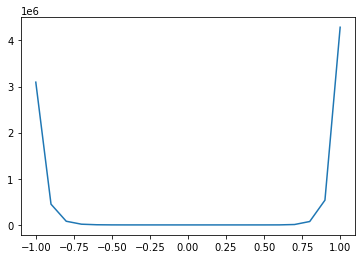

In [6]:
plt.plot(x, y)

In [7]:
torch.cuda.empty_cache()

## Fourier Analysis

Show a model's robustness.

In [8]:
from anatome import fourier_map
map = fourier_map(model, data, F.cross_entropy, 20, (6, 6))

100%|███████████████████████████████████████████| 21/21 [00:03<00:00,  5.63it/s]


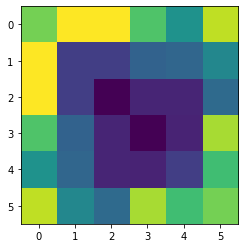

In [9]:
plt.imshow(map, interpolation='nearest')

In [10]:
torch.cuda.empty_cache()